In [658]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown, clear_output
import numpy as np
import random
from matplotlib import colors
# !ls

## Load data

In [659]:
dff = pd.read_csv("cleandata4.csv",delimiter=';')
dff.head(2)

,car-id,car-type,Date,EntryTime,ExitTime,EntryGate,ExitGate,SecondSpent,MinuteSpent,DaysSpent,...,EntryY,ExitX,ExitY,ExitCoordinates,EntryCoordinates,DistanceMiles,SpeedMPH,NoMovement,SpeedLimitViolation,DayOfWeek
0,20154301124328-262,4,2015-05-01,2015-05-01 00:43:00,1970-01-01 00:00:00,entrance3,entrance3,0.0,0.0,0,...,818,564,818,"(564, 818)","(564, 818)",0.00,0.00,True,False,Friday
1,20154301124328-262,4,2015-05-01,2015-05-01 01:03:00,2015-05-01 00:43:00,generalgate1,entrance3,1200.0,20.0,0,...,128,564,818,"(564, 818)","(316, 128)",8.96,26.88,False,True,Friday


In [660]:
dff.columns

Index(['car-id', 'car-type', 'Date', 'EntryTime', 'ExitTime', 'EntryGate',
       'ExitGate', 'SecondSpent', 'MinuteSpent', 'DaysSpent', 'EntryX',
       'EntryY', 'ExitX', 'ExitY', 'ExitCoordinates', 'EntryCoordinates',
       'DistanceMiles', 'SpeedMPH', 'NoMovement', 'SpeedLimitViolation',
       'DayOfWeek'],
      dtype='object')

In [661]:
def time_category_func(hour):  
    if hour >= 18: return "Evening"
    if hour >= 12: return "Noon"
    if hour >= 6: return "Morning"
    if hour >=0 : return "Early Morning"
    
df = dff[["car-id","car-type","Date","EntryTime","ExitTime","EntryGate","ExitGate","ExitCoordinates","EntryCoordinates","DayOfWeek"]].copy()

car_types = { car:f"Type {car}" for car in df["car-type"].unique()}

df['TIME_CAT'] = pd.to_datetime(df['EntryTime']).dt.hour.apply(time_category_func)
df['DATE'] = pd.to_datetime(df.Date)
df['CAR_TYPE'] = df['car-type'].map(car_types)

df.head(2)

,car-id,car-type,Date,EntryTime,ExitTime,EntryGate,ExitGate,ExitCoordinates,EntryCoordinates,DayOfWeek,TIME_CAT,DATE,CAR_TYPE
0,20154301124328-262,4,2015-05-01,2015-05-01 00:43:00,1970-01-01 00:00:00,entrance3,entrance3,"(564, 818)","(564, 818)",Friday,Early Morning,2015-05-01,Type 4
1,20154301124328-262,4,2015-05-01,2015-05-01 01:03:00,2015-05-01 00:43:00,generalgate1,entrance3,"(564, 818)","(316, 128)",Friday,Early Morning,2015-05-01,Type 4


In [662]:
# Util funcs
    
def draw_line_graph( x, y, title, xlabel, ylabel, figsize = (20,10)):
    plt.figure(figsize = figsize)
    plt.bar(x, y,)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def generate_tabs(names:list, fns:list):
    outs = []
    for tab_name, func in zip(names,fns):
        out = widgets.Output()
        with out:
            clear_output()
            func()
        outs.append(out)
    
    tab = widgets.Tab(children = outs)
    for i,name in enumerate(names):
        tab.set_title(i, name)
    display(tab)
    store = {"tab" : tab, "outs": outs }
    return store

# TIME SERIES
 - ### DATE vs TOTAL COUNT of Cars

In [663]:
def get_count_dict_by_date_timecategory_and_car_type(df, gate, time_cat, car_type):
    subset = df if gate == "ALL" else  df[df["EntryGate"]==gate]  
    subset = subset if time_cat=="ALL" else subset[subset["TIME_CAT"]==time_cat]
    subset = subset if car_type=="ALL" else subset[subset["CAR_TYPE"]==car_type]
    res = subset.groupby("DATE")["DATE"].count()
    return res

In [664]:
def TimeSerieshandler():
    valid_gates = np.sort(df.EntryGate.unique())
    valid_car_types = np.sort(df.CAR_TYPE.unique())
    valid_timecat = df.TIME_CAT.unique()

    out1 = widgets.Output()

    gate_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_gates, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))
    time_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_timecat, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))
    car_type_menu = widgets.Dropdown(
                options= np.sort(np.append(valid_car_types, "ALL")),
                value="ALL",
                disabled=False,
                layout=widgets.Layout(width='20%'))

    newgate, newtimecat, newcartype =gate_menu.value, time_menu.value, car_type_menu.value

    def gate_menu_func(c):
        nonlocal newgate
        if c['type'] == 'change' and c['name'] == 'value':
            newgate = c['new']
            render()

    def time_menu_func(c):
        nonlocal newtimecat
        if c['type'] == 'change' and c['name'] == 'value':
            newtimecat = c['new']
            render()

    def car_type_menu_func(c):
        nonlocal newcartype
        if c['type'] == 'change' and c['name'] == 'value':
            newcartype = c['new']
            render()

    def render():
        with out1:
            clear_output()
            res= get_count_dict_by_date_timecategory_and_car_type( df, newgate, newtimecat, newcartype )
            if len(res)>0:
                draw_line_graph( res.index, res.values,
                    f"GATE - {newgate} : Category - {newtimecat} : CarType :{newcartype}",
                    'DATE', 
                    'COUNT OF VEHICLES',
                    figsize=(20,5) )
            else:
                print("No records Available")

    gate_menu.observe(gate_menu_func)
    time_menu.observe(time_menu_func)
    car_type_menu.observe(car_type_menu_func)

    box1 = widgets.HBox(
        [
            widgets.Label(value="Select Gate :"),
            gate_menu, 
            widgets.Label(value="Time Slot:"),
            time_menu,
            widgets.Label(value="Car Type:"),
            car_type_menu,   
        ],layout=widgets.Layout(width='100%', height='50px'))

    W = widgets.VBox([box1,out1])
    display(W)
    render()

In [665]:
TimeSerieshandler()

In [666]:
# _ = generate_tabs(["TAB 1","TAB 2"],[TimeSerieshandler,TimeSerieshandler])

# Network x

In [667]:
df.head(2)

,car-id,car-type,Date,EntryTime,ExitTime,EntryGate,ExitGate,ExitCoordinates,EntryCoordinates,DayOfWeek,TIME_CAT,DATE,CAR_TYPE
0,20154301124328-262,4,2015-05-01,2015-05-01 00:43:00,1970-01-01 00:00:00,entrance3,entrance3,"(564, 818)","(564, 818)",Friday,Early Morning,2015-05-01,Type 4
1,20154301124328-262,4,2015-05-01,2015-05-01 01:03:00,2015-05-01 00:43:00,generalgate1,entrance3,"(564, 818)","(316, 128)",Friday,Early Morning,2015-05-01,Type 4


In [668]:
# all gates as nodes
nodes = df["EntryGate"].unique()

df2 = df.groupby(["EntryGate","ExitGate"])["car-id"].count().reset_index()
df2.head(3)

,EntryGate,ExitGate,car-id
0,camping0,camping0,664
1,camping0,camping2,1
2,camping0,camping3,1


In [669]:
edge_df = df2.rename(columns={"EntryGate":"u","ExitGate":"v","car-id":"weight" })  #u , v are nodes weight = frequencycounts
edge_df.head(3)

,u,v,weight
0,camping0,camping0,664
1,camping0,camping2,1
2,camping0,camping3,1


In [670]:
# edge_scale = 1000
# edge_df.weight = edge_df.weight * edge_scale

In [671]:
import networkx as nx
G = nx.Graph()

In [672]:
gate_coord_df = df.groupby(["EntryGate"])["EntryCoordinates"].first().reset_index()
gate_coord_df.head(3)

,EntryGate,EntryCoordinates
0,camping0,"(258, 206)"
1,camping1,"(632, 248)"
2,camping2,"(218, 318)"


In [673]:
# scale EntryCoordinates between 0 to 1
gate_coord_df["EntryCoordinates"] = gate_coord_df.EntryCoordinates.apply(lambda x: (eval(x)[0]/960, eval(x)[1]/960 ) )

# pass node_pos_dict as {"gate":(cord1,cord2),....}
node_pos_dict = { i[0]: i[1] for i in gate_coord_df.values }
# node_pos_dict

In [674]:
# add edges with weight to G
G.add_weighted_edges_from(edge_df.values)

Network X Analysis on Gate Data


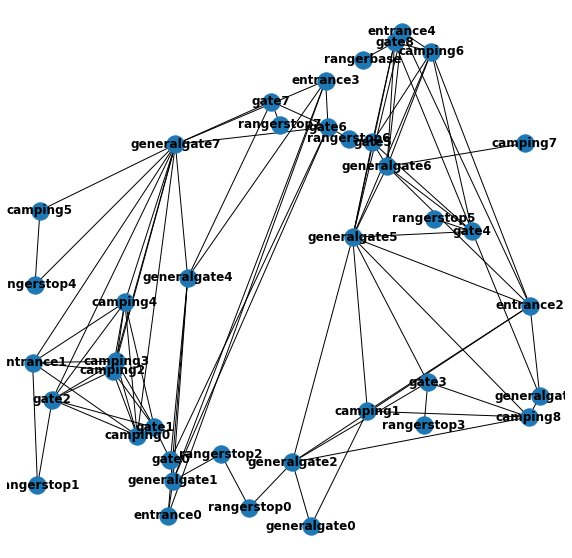

In [675]:
# plot G
print("Network X Analysis on Gate Data")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(G, pos=node_pos_dict, with_labels=True, font_weight='bold',ax=ax)

## Graph with coloured nodes

In [676]:
# get all degree from G and map each degree with unique color.
degree_df = pd.DataFrame(nx.degree(G)).rename(columns={0:"Node",1:"Degree"})

random.seed(10)
degree_color_dict = { deg : random.choice(list(colors.CSS4_COLORS.values() )) for deg in degree_df["Degree"].unique()}
degree_df["Degree_Color"] =degree_df["Degree"].map(degree_color_dict)

# for all nodes in G.nodes get color for each node 
node_colors_G = [degree_df[degree_df.Node==node]["Degree_Color"].values[0] for node in G.nodes]

In [677]:
degree_df.head(3)

,Node,Degree,Degree_Color
0,camping0,9,#FFFF00
1,camping2,9,#FFFF00
2,camping3,9,#FFFF00


Graph with coloured nodes


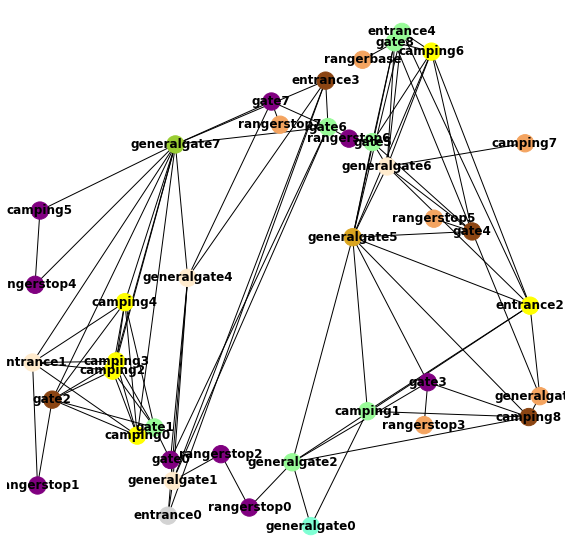

In [678]:
print("Graph with coloured nodes")

# plot G with differnt node_colors
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(G, pos=node_pos_dict, with_labels=True, font_weight='bold',ax=ax,node_color=node_colors_G)

## Graph with Scaled NodeSizes

In [679]:
node_size_scale_f = 200
node_sizes_G = [ int(degree_df[degree_df.Node==node]["Degree"].values[0])*node_size_scale_f for node in G.nodes]

Graph with Scaled NodeSizes


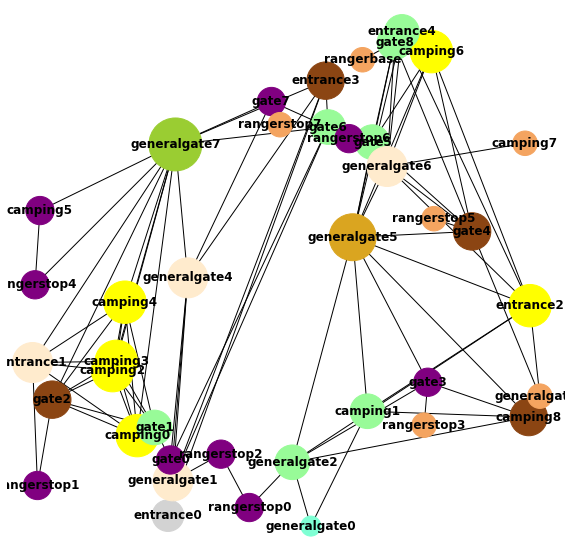

In [680]:
print("Graph with Scaled NodeSizes")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G
)

## Degree Centrality Graph

In [681]:
degree_centrality_dict = nx.degree_centrality(G=G)
scale = 8000
node_sizes_G_byDegreeCentrality = [ scale*degree_centrality_dict[node] for node in G.nodes]

Degree Centrality Graph


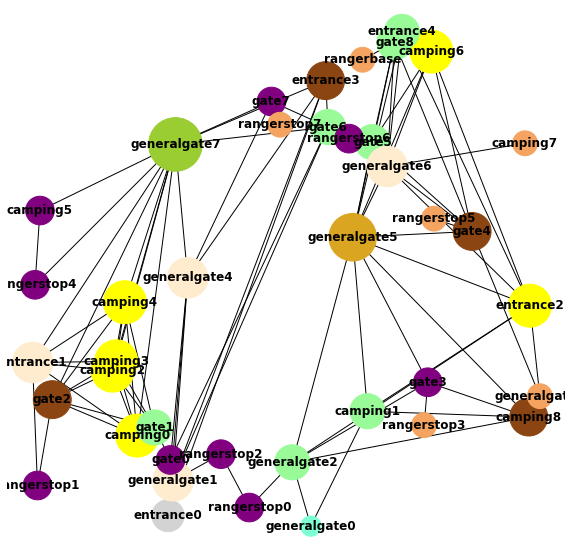

In [682]:
print("Degree Centrality Graph")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G_byDegreeCentrality
)

## Betweenness Centrality Graph

In [683]:
betweenness_centrality_dict = nx.betweenness_centrality(G=G)
scale = 8000
node_sizes_G_byBetweenCentrality = [ scale*betweenness_centrality_dict[node] for node in G.nodes]

Betweenness Centrality Graph


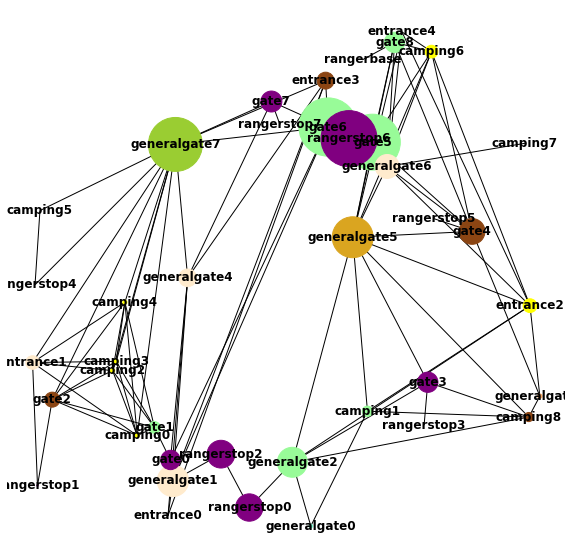

In [684]:
print("Betweenness Centrality Graph")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    node_color=node_colors_G,
    node_size=node_sizes_G_byBetweenCentrality
    
)

# labels = nx.get_edge_attributes(G,'weight')
# _ = nx.draw_networkx_edge_labels(G,node_pos_dict,edge_labels=labels)

## Graph with Edge Width

In [685]:
# for u,v in G.edges():
#     print(u,v, G[u][v]['weight'])

Graph with Edge Width


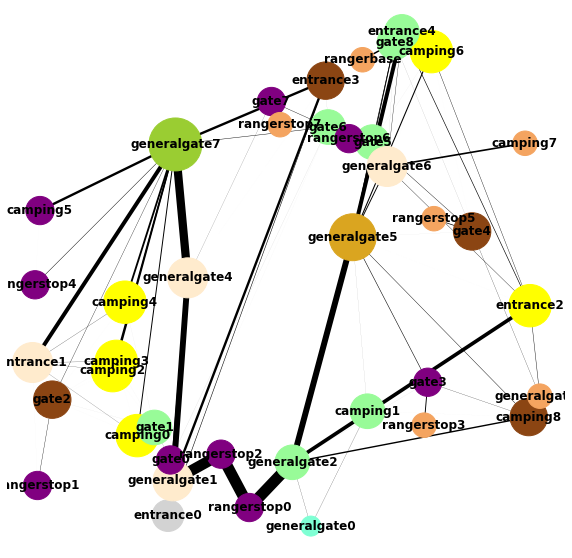

In [686]:
edge_scale = 0.0015
edge_width = [edge_scale * attr['weight'] for u, v,attr in G.edges(data=True)]

print("Graph with Edge Width")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    width= edge_width,
    node_color=node_colors_G,
    node_size=node_sizes_G
)

# labels = nx.get_edge_attributes(G,'weight')
# _ = nx.draw_networkx_edge_labels(G,node_pos_dict,edge_labels=labels)

## Shortest Path 

In [687]:
#  all shortest paths without considering weights
# for path in list(nx.all_shortest_paths(G, "entrance0", "camping1", weight="" )):
#     print(path)

In [688]:
#  all shortest paths considering weights
# for path in list(nx.all_shortest_paths(G, "entrance0", "camping1", weight="weight" )):
#     print(path)

In [689]:
# subnodes = ['entrance0', 'entrance3', 'gate6', 'rangerstop6', 'gate5', 'camping6', 'gate4', 'generalgate5', 'entrance2', 'camping1']
subnodes = ['entrance0', 'entrance3', 'gate6', 'rangerstop6', 'gate5', 'generalgate5', 'camping1']

# create subgraph from G
subG = G.subgraph(subnodes)

Shortest Path Analysis


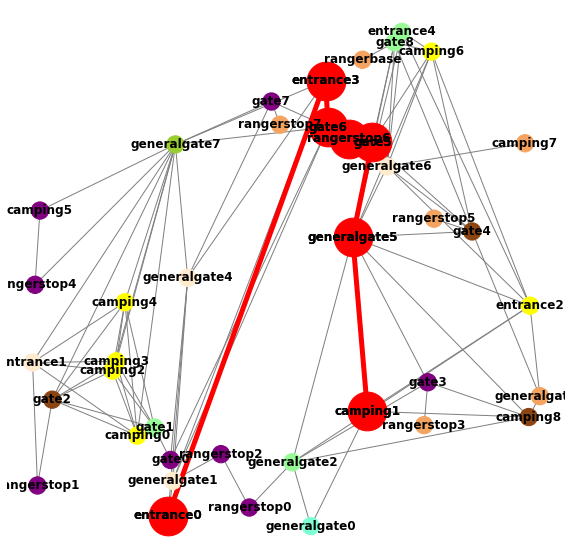

In [690]:
node_colors_GSUB = [degree_df[degree_df.Node==node]["Degree_Color"].values[0] for node in subG.nodes]

subGnode_pos_dict = {}
for n in subnodes:
    subGnode_pos_dict[n] = node_pos_dict[n]

# betweenness_centrality_dict = nx.betweenness_centrality(subG)
# scale = 8000
# node_sizes_G_byBetweenCentrality = [ scale*betweenness_centrality_dict[node] for node in subG.nodes]

# edge_scale = 0.0015
# edge_width = [edge_scale * attr['weight'] for u, v,attr in subG.edges(data=True)]

print("Shortest Path Analysis")
fig,ax = plt.subplots(figsize=(10,10))
nx.draw(
    G, 
    pos=node_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    edge_color='gray',
    node_color=node_colors_G,
)
nx.draw(
    subG, 
    pos=subGnode_pos_dict, 
    with_labels=True, 
    font_weight='bold',
    ax=ax,
    width= 5,
#     node_color=node_colors_GSUB,
    node_color="red",
    edge_color='red',
    node_size=1500
    
)

# labels = nx.get_edge_attributes(G,'weight')
# _ = nx.draw_networkx_edge_labels(G,node_pos_dict,edge_labels=labels)